In [517]:
%pylab inline
from em_examples.HarmonicVMDCylWidget import HarmonicVMDCylWidget
from em_examples.BiotSavart import BiotSavartFun
from SimPEG import Utils, Mesh
import matplotlib

Populating the interactive namespace from numpy and matplotlib


In [568]:
matplotlib.rcParams['font.size'] = 16

In [767]:
vmd = HarmonicVMDCylWidget()
h1 = 20
h2 = 20
Sigma0 = 1e-8
Sigma1 = 1e-2
Sigma2 = 1e-2
Sigma3 = 1e-2
z = 20.
rxOffset = 8.
Frequency = np.logspace(2, 5, 31)
bType = "bSecondary"
m = vmd.setThreeLayerParam(h1=h1, h2=h2, sig0=Sigma0, sig1=Sigma1, sig2=Sigma2, sig3=Sigma3)
srcLoc = np.array([0., 0., z])
rxLoc = np.array([[rxOffset, 0., z]])
dpred = vmd.simulate(srcLoc, rxLoc, Frequency)
vmd.getFields(bType=bType)
vmd.getData(bType=bType)
data = vmd.Bz
# dataz_half = data.copy()

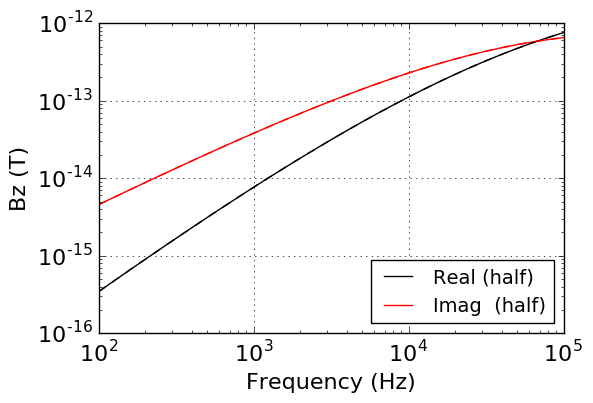

In [788]:
# plt.loglog(Frequency, abs(dataz_half.real), 'k')
# plt.loglog(Frequency, abs(dataz_half.imag), 'r')
# plt.loglog(Frequency, abs(data.real), 'k--')
# plt.loglog(Frequency, abs(data.imag), 'r--')
# plt.legend(("Real (half)", "Imag  (half)", "Real", "Imag"), loc=4, fontsize = 14)
# plt.legend(("Real (half)", "Imag  (half)"), loc=4, fontsize = 14)
# plt.grid(True)
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Bz (T)")    


In [769]:
xmax = 100.
zmax, zmin = 100, -100
xind = (vmd.mesh.vectorCCx <= xmax) 
yind = np.logical_and(vmd.mesh.vectorCCz >= zmin, vmd.mesh.vectorCCz <= zmax)

In [770]:
nx = xind.sum()
ny = yind.sum()

In [771]:
hx = np.r_[vmd.mesh.hx[xind][::-1], vmd.mesh.hx[xind]]
hz = vmd.mesh.hz[yind]
mesh2D = Mesh.TensorMesh([hx, hz], x0="CC")
def mirrorArray(x, nx, ny):
    X = x.reshape((nx, ny), order="F")
    X2 = np.vstack((np.flipud(X), X))
    return X2

In [772]:
# vmd.plotField()

In [773]:
import scipy.sparse as sp
from scipy.constants import mu_0

Gz = BiotSavartFun(vmd.mesh, rxLoc, component='z')
Gx = BiotSavartFun(vmd.mesh, rxLoc, component='x')
src = vmd.srcList[0]
Jy = Utils.sdiag(vmd.prb.sigma) * vmd.mesh.aveE2CC*vmd.f[:, "e"]

dataz = (Gz.dot(np.vstack((np.ones_like(Jy), Jy, np.ones_like(Jy))))).flatten()
vmd.getData(bType=bType)

In [774]:
from ipywidgets import *

In [775]:
print EM1DAnal.SkinDepth(0.01, np.r_[1e5, 1e4, 1e3])

[  15.91549431   50.3292121   159.15494309]


In [786]:
r = np.logspace(0, 2.8, 31)
thres_perc = 0.05

def footprint(r):
    actind = (vmd.mesh.gridCC[:,2] > -r)  & (vmd.mesh.gridCC[:,2] < 0.) 
    dataz_footprint = (Gz[:,np.r_[actind, actind, actind]].dot(np.vstack((np.ones_like(Jy[actind,:]), Jy[actind,:], np.ones_like(Jy[actind,:]))))).flatten()
    return dataz_footprint

doi_r = []
doi_i = []
ratio_r = []
ratio_i = []
for r_temp in r:
    temp = footprint(r_temp)    
    ratio_r.append(abs(temp.real-dataz.real) / abs(dataz.real))
    ratio_i.append(abs(temp.imag-dataz.imag) / abs(dataz.imag))
    
# # r_temp = r[4]
#     temp = footprint(r_temp)
#     ratio_r = abs(temp.real / dataz.real - 1.)
#     ratio_i = abs(temp.imag / dataz.imag - 1.)
#     actind_r = ratio_r > thres_perc
#     actind_i = ratio_i > thres_perc
#     if actind_r.sum() == 0:
#         doi_r.append(Frequency.min())
#     elif actind_r.sum() == Frequency.size:
#         doi_r.append(Frequency.max())        
#     else:
#         ifreq = np.arange(Frequency.size)[~actind_r][0]-1
#         doi_r.append(Frequency[ifreq])        
        
#     if actind_i.sum() == 0:
#         doi_i.append(Frequency.min())
#     elif actind_i.sum() == Frequency.size:
#         doi_i.append(Frequency.max())                
#     else:
#         ifreq = np.arange(Frequency.size)[~actind_i][0]-1        
#         doi_i.append(Frequency[ifreq])
ratio_r = np.vstack(ratio_r)
ratio_i = np.vstack(ratio_i)
for ifreq in range(Frequency.size):
    doi_r.append(r[ratio_r[:,ifreq] < thres_perc].min())     
    doi_i.append(r[ratio_i[:,ifreq] < thres_perc].min())     
    
doi_r = np.hstack(doi_r)
doi_i = np.hstack(doi_i)


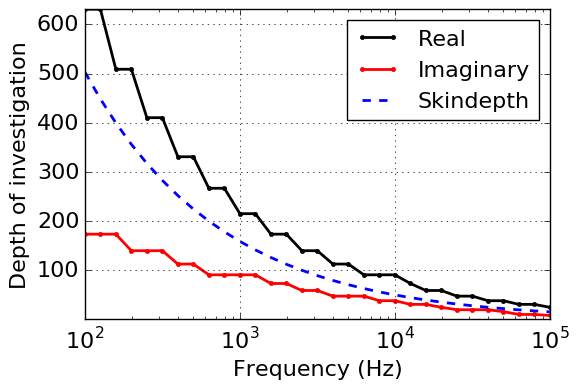

In [787]:
from simpegem1d import EM1DAnal
plt.semilogx(Frequency, doi_r,  'k.-', lw=2)
plt.semilogx(Frequency, doi_i,  'r.-', lw=2)
plt.semilogx(Frequency, EM1DAnal.SkinDepth(0.01, Frequency), '--', lw=2)
plt.legend(("Real", "Imaginary", "Skindepth"), fontsize = 16)
plt.ylim(r.min(), r.max())
plt.xlim(Frequency.min(), Frequency.max())
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Depth of investigation")

<function __main__.footprint_plot>

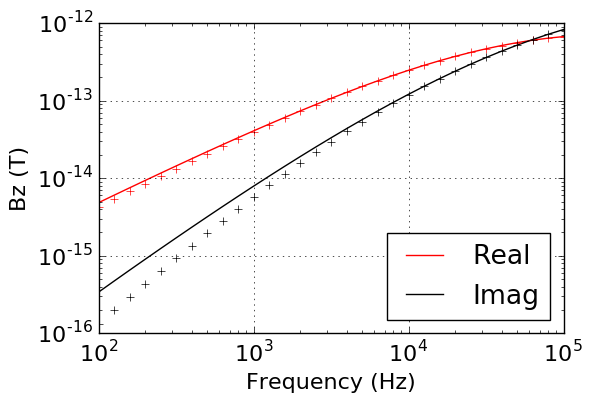

In [780]:
def footprint_plot(r):
# r = 100.
#     actind = (abs(vmd.mesh.gridCC[:,0]) < r) & (vmd.mesh.gridCC[:,2] > -r) 
    actind = (vmd.mesh.gridCC[:,2] > -r)  & (vmd.mesh.gridCC[:,2] < 0.) 
    dataz_footprint = (Gz[:,np.r_[actind, actind, actind]].dot(np.vstack((np.ones_like(Jy[actind,:]), Jy[actind,:], np.ones_like(Jy[actind,:]))))).flatten()
    plt.loglog(Frequency, abs(dataz.imag), 'r')
    plt.loglog(Frequency, abs(dataz.real), 'k')
    plt.loglog(Frequency, abs(dataz_footprint.imag), 'r+')
    plt.loglog(Frequency, abs(dataz_footprint.real), 'k+')
    plt.legend(("Real", "Imag"), loc=4)
    plt.grid(True)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Bz (T)")    
# plt.loglog(Frequency, -vmd.Bz.imag, 'r.')
# plt.loglog(Frequency, -vmd.Bz.real, 'k.')
interact(footprint_plot, r=FloatText(value=100., description="Footprint (m)"))